# Example 1: A *dressed* quantum circuit as hybrid classifier.

This notebook defines a hybrid quantum-classical neural network which is applied to a non-linear classification problem.

The network model is the "dressed quantum circuit" defined in Ref. [1], i.e., a variational quantum classifier placed in between two classical layers. The main computation is performed by the central quantum circuit, while the first and last classical layers act as trainable embedding and decoding blocks respectively.

Part of this code, especially the graphical representation of synthetic datasets, is inspired by the sci-kit learn example: "*[Classifier comparison](https://github.com/scikit-learn/scikit-learn/blob/master/examples/classification/plot_classifier_comparison.py)* ".

## General setup
The main packages imported in this notebook are: the quantum
software framework `pennylane` [2], the python plotting library `matplotlib` and the machine learning package `sklearn`.

In [1]:
# OpenMP: number of parallel threads.
%env OMP_NUM_THREADS=1

# Plotting
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# PennyLane
import pennylane as qml
from pennylane import numpy as np

# Optimized logsumexp().
# from scipy.misc import logsumexp      # Working but deprecated
# from scipy.special import logsumexp   # May gives problems with autograd.

# Adam optimizer
from pennylane.optimize import AdamOptimizer

# Timing tool
import time

# Scikit-learn tools
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

env: OMP_NUM_THREADS=1


Setting of the main parameters associated with the network model and with the dataset.<br>
**Remark:** To reproduce the results of [the paper], `N_total_iterations` should be set to 1000 which may take many hours. We suggest to first try with only a few iterations, just to check that everything runs smoothly.

In [2]:
n_qubits = 5               # Number of qubits
step = 0.07                # Learning rate
batch_size = 10            # Numbre of samples (points) for each mini-batch
data_noise = 0.2           # Spread of the data points around the spirals  
q_depth = 5                # Depth of the quantum circuit (number of variational layers)
rng_w_state = 55           # Seed for random initial weights
n_input_nodes = 2          # 2 input nodes (x and y coordinates of data points).        
classes = [0,1]            # Class 0 = red points. class 1 = blue points.
n_classes = len(classes)
N_train = 2000             # Number of training points
N_batches = N_train // batch_size          # Number of training batches
N_total_iterations =  1000                 # Number of optimization steps (step= 1 batch)
noise_0 = 0.001                            # Initial spread of random weight vector
N_test = 200                               # Number of test points
N_tot = N_train + N_test                   # Total number of points
n_quantum_layers = 15                      # Keep 15 even if not all are used
h = 0.2                                    # Plot grid step size
start_time = time.time()                   # Start the computation timer
cm = plt.cm.RdBu                           # Test point colors
cm_bright = ListedColormap(['#FF0000', '#0000FF']) # Train point colors

Let us initialize a PennyLane device as a ProjectQ quantum simulator. If missing, the ProjectQ plugin can be installed by running: `python -m pip install pennylane_pq`

In [3]:
dev = qml.device('projectq.simulator', wires=n_qubits)

Initialize a vector of random weights that will be trained later. The weights of several layers are concatenated into a large single 1D vector named `weights_flat_0`

In [4]:
# Number of pre-processing parameters (1 matrix and 1 intercept)
n_pre = n_qubits * (n_input_nodes + 1)

# Number of quantum node parameters (1 row of rotations per layer)
n_quant = n_quantum_layers * n_qubits

# Number of classical node parameters (1 matrix and 1 intercept)
n_class = n_qubits * (n_qubits + 1)

# Number of post-processing parameters (1 matrix and 1 intercept)
n_post = n_classes * (n_qubits + 1)        

# Set seed of random number generator
rng_w = np.random.RandomState(rng_w_state)

# Initialize a unique vector of random parameters.
weights_flat_0 = noise_0 * rng_w.randn(n_pre + n_quant + n_class + n_post) 

Specify the classifiers to be studied and their names.

In [5]:
classifiers = ["Classical", "Quantum"]
names = ["Entirely classical", "Dressed quantum"]

## Synthetic benchmark datasets 
Generate two datasets of 2D points, each one organized in two spiral-shaped classes. Two-dimensional datasets are very instructive because they can be easily visualized.

In [6]:
def twospirals(n_points, noise=0.7, turns=1.52, random_state=None):
        """Returns the two spirals dataset."""
       
        if random_state == None:
            rng_sp = np.random
        else:
            rng_sp = np.random.RandomState(random_state) 
        n = np.sqrt(rng_sp.rand(n_points, 1)) * turns * (2 * np.pi)
        d1x = -np.cos(n) * n + rng_sp.rand(n_points, 1) * noise
        d1y = np.sin(n) * n + rng_sp.rand(n_points, 1) * noise
        return (np.vstack((np.hstack((d1x,  d1y)),np.hstack((-d1x, -d1y)))), 
                np.hstack((np.zeros(n_points).astype(int),np.ones(n_points).astype(int))))

datasets = [twospirals(N_tot, random_state=21, turns=1.52),
            twospirals(N_tot, random_state=21, turns=2.0),
           ]

def digits2position(vec_of_digits, n_positions):
        """One-hot encoding of a batch of vectors. """
        return np.eye(n_positions)[vec_of_digits]

def position2digit(exp_values):
        """Inverse of digits2position()."""
        return np.argmax(exp_values)

Let us give a look at the datasets.

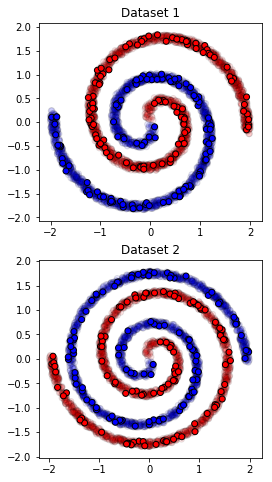

In [7]:
figure_dataset = plt.figure("dataset",figsize=(4, 4 * len(datasets)))
for ds_cnt, ds in enumerate(datasets):
        
        # Normalize dataset and split into training and test part
        X, y = ds
        X = StandardScaler().fit_transform(X)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=N_test, random_state=42)
        
        # Plot the dataset
        ax = plt.subplot(len(datasets), 1, ds_cnt +1)
        ax.set_title("Dataset %d" % (ds_cnt+1))
        
        # Plot training points
        ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
                edgecolors='k',alpha=0.1)
        
        # Plot test points
        ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright,
                edgecolors='k')

Red and blue colors are the two classes that we want to distinguish.<br>
The vivid points in the foreground are the test data, while the pale points in the background are the training data.<br> 
Both shapes are highly non-linear and therefore relatively hard to classify (linear methods do not work). Moreover the second dataset is even more twisted wrt to the first, so we expect it to give worst classification results.

## Network model: the *dressed* quantum circuit.

A _dressed_ quantum circuit [1] is a variational quancum circuit "sandwiched" between two  classical layers.

Let us first define the classical pre-processing and post-processing layers.

In [8]:
def pre_processing_net(pre_weights_flat, data_point=None):
    """Classical layer which preprocesses data. The output
    should be a feature vector suitable to be injected into a quantum network.
    """
    # Reshape weights
    pre_weights = pre_weights_flat.reshape(n_qubits, n_input_nodes + 1)
    
    # Affine operation
    pre_one = np.dot(pre_weights[:, :-1], data_point) + pre_weights[:, -1]
    
    # Non-linear activation
    pre_out = np.tanh(pre_one)
    
    return pre_out

def post_processing_net(post_weights_flat, post_in):
    """Classical layer which postprocesses data. The input
    should be a vector of expectation values of a quantum network.
    """
    # Reshape weights
    post_weights = post_weights_flat.reshape(n_classes, n_qubits + 1)
    
    # Affine operation
    post_one = np.dot(post_weights[:, :-1],post_in) + post_weights[:, -1]
    
    # LogSumExp normalization layer. Choose between scipy or NumPy functions.
    
    # With scipy logsumexp
    # post_out = post_one - logsumexp(post_one, axis=0, keepdims=True) 
    
    # Directly with NumPy functions
    post_out = post_one - np.log(np.sum(np.exp(post_one), axis=0))

    return post_out

Now we define some preliminary quantum layers that will compose the quantum circuit.

In [9]:
def H_layer(nqubits):
    """Layer of single-qubit Hadamard gates.
    """
    for idx in range(nqubits):
        qml.Hadamard(wires=idx)
        
def RY_layer(w):
    """Layer of parametrized qubit rotations around the y axis.
    """
    for idx, element in enumerate(w):
        qml.RY(element, wires=idx)
        
def entangling_layer(nqubits):
    """Layer of CNOTs followed by another shifted layer of CNOTs.
    """
    # In other words it should apply something like :
    # CNOT CNOT CNOT CNOT... CNOT
    #  CNOT CNOT CNOT... CNOT
    
    # Loop over even indices: i=0,2,...N-2
    for i in range(0, nqubits - 1, 2): 
        qml.CNOT(wires=[i, i + 1])
        
    # Loop over odd indices: i=1,3,...N-3
    for i in range(1, nqubits - 1, 2):
        qml.CNOT(wires=[i, i + 1])

We can now define the quantum circuit by using the PennyLane `qnode` decorator . The structure is that of a typical
variational quantum circuit:
1. All qubits are first initialized in a balanced superposition of *up* and *down* states, then they are rotated according to the input parameters (local embedding);
2. Successively a sequence of trainable rotation layers and constant entangling layers is applied. This block is responsible for the main computation necessary to solve the classification problem.
3. Eventually, for each qubit, the local expectation value of the Z operator is measured. This produces a classical output vector, suitable for additional post-processing.

In [10]:
@qml.qnode(dev)
def q_net(q_weights_flat, q_in):
        
        # Reshape weights
        q_weights = q_weights_flat.reshape(n_quantum_layers, n_qubits)
        
        # Start from unbiased |+> state w.r.t. |0> and |1>
        H_layer(n_qubits)
        
        # Embed features in the quantum node
        RY_layer(q_in)    

        # Sequence of trainable variational layers
        for k in range(q_depth):
            entangling_layer(n_qubits)
            RY_layer(q_weights[k + 1])
         
        # Expectation values in the Z basis.
        exp_vals = [qml.expval.PauliZ(position) for position in range(n_qubits)]
        return tuple(exp_vals)

We also introduce a classical analogue of the quantum circuit. This will be used to define a fully
classical benchmark to be compared with our hybrid model.

In [11]:
def c_net(c_weights_flat, c_in):
    """Classical network which should replace the quantum node in order to make
    a relatively fair classical/quantum comparison.
    """
    
    # Reshape weights
    c_weights = c_weights_flat.reshape(n_qubits, n_qubits + 1)
    
    # Classical layers
    c_one = np.dot(c_weights[:, :-1], c_in) + c_weights[:, -1]
    return np.tanh(c_one)

We can finally define our full model as a *dressed* quantum circuit. Note that by setting the keyword `node` to `"classical"`, the network becomes completely classical.

In [12]:
def full_network(weights_flat, data_point=None, node="quantum"):
        """Full neural network including all quantum and classical layers.
        """    
        
        # Split weight vector into four vectors: 
        # Pre-processing layer parameters
        pre_weights_flat =weights_flat[:n_pre]
        
        # Quantum circuit parameters
        q_weights_flat = weights_flat[n_pre:n_pre+n_quant]
        
        # Classical benchmark parameters
        c_weights_flat = weights_flat[n_pre+n_quant:n_pre+n_quant+n_class]
        
        # Post-processing layer parameters
        post_weights_flat = weights_flat[n_pre+n_quant+n_class:]
        
        # Application of classical pre-processing layer
        pre_out=pre_processing_net(pre_weights_flat,data_point=data_point)
        
        # Quantum circuit
        if node=="quantum":
            # Rescale [-1,1] to [-pi/2,pi/2]
            q_in=pre_out*np.pi/2.0 
            net_out = q_net(q_weights_flat, q_in)
        
        # Classical benchmark
        if node=="classical":
            net_out = c_net(c_weights_flat, pre_out)
        
        # Application of classical post-processing layer  
        post_out = post_processing_net(post_weights_flat,net_out)
        return post_out 

## Training loop and results
Before actually training the network we need to define the *cost* or *loss* function.

In [13]:
def cost_function(weights_flat, points, labels,node=None):
    """Objective function to be minimized by the training process"""
    
    predictions = [full_network(weights_flat, data_point=point, node=node) for point in points]
    log_like = np.sum(predictions * labels)   
    return -log_like

def cost_from_output(weights_flat, net_out_list, labels):
    """Cost as a function of the list of network output"""
    
    log_like = np.sum(net_out_list * labels)
    return -log_like    

def accuracy(predictions, labels):
    """Returns fraction of correct predictions."""
    
    predicted_digits = np.array([position2digit(item) for item in predictions])
    label_digits = np.array([position2digit(item) for item in labels])
    return np.sum(predicted_digits == label_digits) / len(label_digits)

Loop over datasets and algorithms (dressed quantum, fully classical). For each dataset and algorithm, independent training and test processes are performed. The results are graphically shown when the training loop is completed.

Training  Entirely classical ...


ValueError: object arrays are not supported

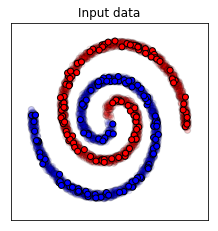

In [14]:
# Initialize the figure that will contain the final plots.
figure_main = plt.figure("main",figsize=(4 * (len(classifiers) + 1), 4 * len(datasets)))

i = 1
# Iterate over datasets
for ds_cnt, ds in enumerate(datasets):
        # Normalize dataset and split into training and test part
        X, y = ds
        X = StandardScaler().fit_transform(X)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=N_test, random_state=42)
        
        # Plot settings
        x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
        y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h),np.arange(y_min, y_max, h))

        # First, just plot the dataset
        ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
        if ds_cnt == 0:
            ax.set_title("Input data")
        
        # Plot training points
        ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
                edgecolors='k', alpha=0.1)
        
        # Plot test points
        ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright,
                edgecolors='k')
        ax.set_xlim(xx.min(), xx.max())
        ax.set_ylim(yy.min(), yy.max())
        ax.set_xticks(())
        ax.set_yticks(())
        i += 1

        # Iterate over classifiers
        grid_points = np.c_[xx.ravel(), yy.ravel()]
        for name, clf in zip(names, classifiers):
                print("Training ", name, "...")
                node = None   
                if clf == "Quantum": 
                    node = "quantum"
                if clf == "Classical":
                    node = "classical" 
                
                # ===============================
                #       Netrwork training          
                # ===============================
                
                opt_weights = None 
                rng_shuff = np.random.RandomState(150)
                train_history = []
                train_cost_history = []           
                y_train_onehot = digits2position(y_train, n_classes)
                y_test_onehot = digits2position(y_test, n_classes)
                opt = AdamOptimizer(step)
                
                # Start with random weigths
                opt_weights = weights_flat_0  
                
                # Training iteration loop
                offset = 0
                for it in range(N_total_iterations):
                    start_it_time = time.time()
                    
                    # If all train data has been used, then reshuffle
                    if offset > N_train - 1:       
                        indices = np.arange(N_train)  
                        rng_shuff.shuffle(indices)
                        X_train = X_train[indices]
                        y_train = y_train[indices]
                        y_train_onehot = y_train_onehot[indices]   
                        offset = 0
                        
                    train_data_batch = X_train[offset : offset + batch_size]
                    train_labels_batch = y_train_onehot[offset : offset + batch_size]
                    
                    # Step of Adam optimizer
                    opt_weights = opt.step(lambda w: cost_function(w, train_data_batch, train_labels_batch, node=node), opt_weights)
                    
                    # Iteration results
                    training_pred = np.asarray([full_network(opt_weights, data_point=point, node=node) for point in train_data_batch])
                    train_history.append(accuracy(training_pred, train_labels_batch))
                    train_cost_history.append(cost_from_output(opt_weights, training_pred, train_labels_batch))
                    
                    # Print info for each iteration
                    total_it_time = time.time() - start_it_time
                    minutes_it = total_it_time // 60
                    seconds_it = round(total_it_time - minutes_it * 60)
                    print('Iteration: %4d of %4d. Time:%3d min %3d sec.' %(it + 1, N_total_iterations, minutes_it, seconds_it), end="\r", flush=True)
                    offset += batch_size 
                
                # ================================
                #        Netrwork testing      
                # ================================
                
                print('\nComputing accuracy on test data...')
                test_pred = np.asarray( [full_network(opt_weights, data_point=point, node=node) for point in X_test])
                score = accuracy(test_pred, y_test_onehot)
                print('Test accuracy: %4.3f ' %(score))  
                
                
                # ======================
                #        Plotting     
                # ======================
                
                # In order to draw the decision border we 
                # compute predictions for the whole 2D plane.
                grid_results = np.asarray( [full_network(opt_weights, data_point=point, node=node) for point in grid_points])
                
                # Decision function: negative for class 0, positive for class 1.
                Z = np.tanh(grid_results[:, 1] - grid_results[:, 0])
                Z = Z.reshape(xx.shape)
                
                # Add subplot to the main figure.
                ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
                ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)
                
                # Plot training points
                ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
                        edgecolors='k', alpha=0.1)
                
                # Plot test points
                ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright,
                        edgecolors='k')
                ax.set_xlim(xx.min(), xx.max())
                ax.set_ylim(yy.min(), yy.max())
                ax.set_xticks(())
                ax.set_yticks(())
                
                # Add model names as titles
                if ds_cnt == 0:
                    ax.set_title(name)
                ax.text(xx.max() - .3, yy.min() + .3, ('%.2f' % score).lstrip('0'),
                        size=15, horizontalalignment='right')
                i += 1

# Print final results
total_time = time.time() - start_time
minutes = total_time // 60
seconds = round(total_time - minutes * 60)
print("Total time: ", minutes, " min, ", seconds, " seconds")
print("\n")

# Show the final figure
plt.tight_layout()
plt.show()

## References

[1] Andrea Mari, Thomas R. Bromley, Josh Izaac, Maria Schuld, and Nathan Killoran. _Transfer learning in hybrid classical-quantum neural networks_. [arXiv:xxxx.xxxx](https://arxiv.org/abs/xxxx.xxxx), (2019).

[2] Ville Bergholm, Josh Izaac, Maria Schuld, Christian Gogolin, Carsten Blank, Keri McKiernan, and Nathan Killoran. PennyLane: Automatic differentiation of hybrid quantum-classical computations. [arXiv:1811.04968](https://arxiv.org/abs/1811.04968), (2018).